In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import make_pipeline as imb_pipe
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier

import pickle

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
sns.set(style="darkgrid",font_scale=1)
sns.set_palette("nipy_spectral", 8, .5)
pd.set_option("display.max.rows",None)
pd.set_option("display.max.columns",None)

import os

In [2]:
raw_data_path = 'datasets/diabetes_012_health_indicators_BRFSS2015.csv'
processed_data_path = 'datasets/diab_processed.csv'

In [3]:
df = pd.read_csv(raw_data_path)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_012          253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


# Exploration & Feature Engineering

In [8]:
# check for duplicates
df.duplicated().sum()

23899

In [9]:
# check nan values
df.isna().any().sum()

0

In [10]:
# check cardinality
df.nunique()

Diabetes_012             3
HighBP                   2
HighChol                 2
CholCheck                2
BMI                     84
Smoker                   2
Stroke                   2
HeartDiseaseorAttack     2
PhysActivity             2
Fruits                   2
Veggies                  2
HvyAlcoholConsump        2
AnyHealthcare            2
NoDocbcCost              2
GenHlth                  5
MentHlth                31
PhysHlth                31
DiffWalk                 2
Sex                      2
Age                     13
Education                6
Income                   8
dtype: int64

* drop duplicates
* no null values
* explore columns further for cardinality

In [67]:
df.drop_duplicates(inplace=True)

<Axes: xlabel='Diabetes_012', ylabel='count'>

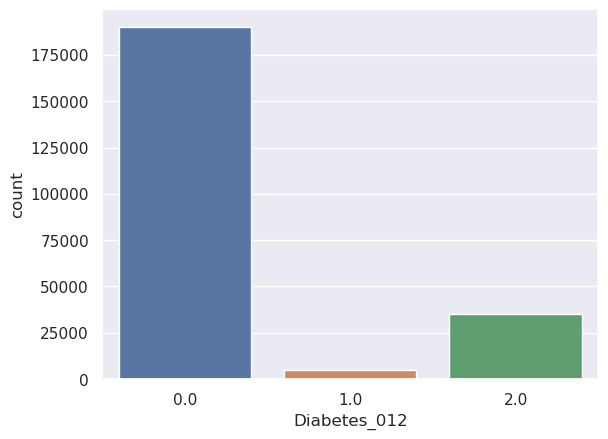

In [12]:
# explore target
sns.countplot(data=df, x='Diabetes_012')

* do oversampling of dataset
* correllation between GenHlth and PhysHlth to Explore further

In [68]:
df.corr()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
Diabetes_012,1.000000,0.261976,0.203327,0.075701,0.212027,0.046774,0.100276,0.170816,-0.103408,-0.025462,-0.043446,-0.067164,0.024911,0.023568,0.284881,0.057698,0.160485,0.210638,0.032243,0.184642,-0.107742,-0.147102
HighBP,0.261976,1.000000,0.284186,0.111220,0.194126,0.074237,0.124426,0.201271,-0.104131,-0.019329,-0.042853,-0.014218,0.052084,0.002216,0.272562,0.037374,0.144413,0.211498,0.047155,0.339808,-0.112676,-0.139782
HighChol,0.203327,0.284186,1.000000,0.094753,0.089615,0.074627,0.089258,0.176279,-0.063266,-0.026125,-0.027254,-0.019104,0.052412,0.002900,0.187929,0.050212,0.110801,0.135826,0.022894,0.263866,-0.049838,-0.061871
CholCheck,0.075701,0.111220,0.094753,1.000000,0.042420,-0.003776,0.027894,0.049995,-0.004409,0.017973,-0.000537,-0.021043,0.115539,-0.054198,0.062782,-0.001549,0.040612,0.048969,-0.024255,0.095996,-0.009758,0.002161
BMI,0.212027,0.194126,0.089615,0.042420,1.000000,-0.009196,0.011062,0.039926,-0.127864,-0.067528,-0.044185,-0.058334,-0.008560,0.045837,0.208411,0.068653,0.102844,0.182604,0.030989,-0.049347,-0.074568,-0.069192
Smoker,0.046774,0.074237,0.074627,-0.003776,-0.009196,1.000000,0.054438,0.105154,-0.066981,-0.061947,-0.013892,0.096052,-0.013983,0.037353,0.134979,0.077715,0.100514,0.108179,0.096709,0.107653,-0.135793,-0.095418
Stroke,0.100276,0.124426,0.089258,0.027894,0.011062,0.054438,1.000000,0.198863,-0.059440,-0.004613,-0.033141,-0.021272,0.013565,0.028691,0.169870,0.062111,0.140919,0.169442,0.003560,0.128040,-0.064319,-0.117232
HeartDiseaseorAttack,0.170816,0.201271,0.176279,0.049995,0.039926,0.105154,0.198863,1.000000,-0.073267,-0.007128,-0.027330,-0.035453,0.025899,0.022076,0.246411,0.052756,0.170473,0.202779,0.089717,0.223626,-0.082466,-0.122908
PhysActivity,-0.103408,-0.104131,-0.063266,-0.004409,-0.127864,-0.066981,-0.059440,-0.073267,1.000000,0.125283,0.135478,0.023190,0.024095,-0.046620,-0.237676,-0.106175,-0.199562,-0.235943,0.033586,-0.087539,0.171224,0.166171
Fruits,-0.025462,-0.019329,-0.026125,0.017973,-0.067528,-0.061947,-0.004613,-0.007128,0.125283,1.000000,0.243114,-0.028357,0.022756,-0.032521,-0.071433,-0.052409,-0.024744,-0.030188,-0.088628,0.073726,0.085174,0.051230


<Axes: >

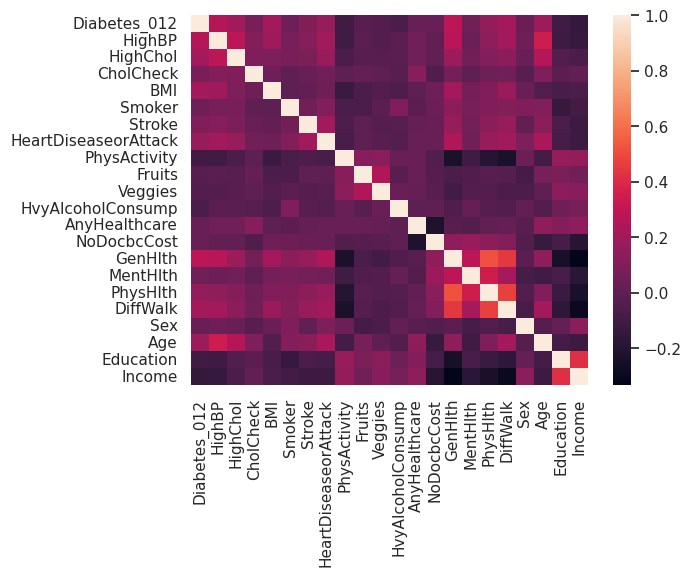

In [69]:
sns.heatmap(df.corr())

In [70]:
df[['GenHlth', 'PhysHlth']].corr()

,GenHlth,PhysHlth
GenHlth,1.000000,0.516508
PhysHlth,0.516508,1.000000


In [71]:
df[['GenHlth', 'DiffWalk']].corr()

,GenHlth,DiffWalk
GenHlth,1.000000,0.446735
DiffWalk,0.446735,1.000000


In [72]:
df['GenHlth'].unique()

array([5., 3., 2., 4., 1.])

In [73]:
df['PhysHlth'].unique()

array([15.,  0., 30.,  2., 14., 28.,  7., 20.,  3., 10.,  1.,  5., 17.,
        4., 19.,  6., 12., 25., 27., 21., 22.,  8., 29., 24.,  9., 16.,
       18., 23., 13., 26., 11.])

GenHlth is general health rating, from 1 - 5. The higher the better
PhysHlth is number of poor health days in past 30 days. The lower the better!
How come they have such positive correlation?

* Put PhysHlth in categories
* Do same for MntlHlth

In [74]:
def categorize_HlthDay(count):
    """ Put the days into categories.
        The count is the number of days of ill-health in the past month
        so, the fewer the better
        0 - 6: 1 (Excellent health)
        7 - 12: 2 (Very Good)
        13 - 18: 3 (Good)
        19 - 24: 4 (Poor)
        25 - 30: 5 (Very poor)

    Args:
        count(int/float): the count for a row
    
    Return:
        the category(str)
    """
    if count >= 25:
        return (5)
    elif count >= 19:
        return (4)
    elif count >= 13:
        return (3)
    elif count >= 7:
        return (2)
    else:
        return (1)


In [75]:
df['PhysHlthCat'] = df['PhysHlth'].apply(categorize_HlthDay)
df['MentHlthCat'] = df['MentHlth'].apply(categorize_HlthDay)

In [76]:
df.head()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,PhysHlthCat,MentHlthCat
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0,3,3
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0,1,1
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0,5,5
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0,1,1
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0,1,1


In [78]:
# check correlation again
df[['GenHlth', 'PhysHlthCat']].corr()

,GenHlth,PhysHlthCat
GenHlth,1.000000,0.498599
PhysHlthCat,0.498599,1.000000


In [79]:
df[['GenHlth', 'PhysActivity']].corr()

,GenHlth,PhysActivity
GenHlth,1.000000,-0.237676
PhysActivity,-0.237676,1.000000


In [80]:
df[['HighChol', 'CholCheck']].corr()

,HighChol,CholCheck
HighChol,1.000000,0.094753
CholCheck,0.094753,1.000000


no correlation here

### Assess Finances and Access

In [52]:
df[['AnyHealthcare', 'NoDocbcCost', 'Income']].corr()

,AnyHealthcare,NoDocbcCost,Income
AnyHealthcare,1.000000,-0.227625,0.146313
NoDocbcCost,-0.227625,1.000000,-0.187760
Income,0.146313,-0.187760,1.000000


In [81]:
df['CostAccess'] = df['AnyHealthcare'] + df['NoDocbcCost']
df[['AnyHealthcare', 'NoDocbcCost', 'CostAccess']].head()

,AnyHealthcare,NoDocbcCost,CostAccess
0,1.0,0.0,1.0
1,0.0,1.0,1.0
2,1.0,1.0,2.0
3,1.0,0.0,1.0
4,1.0,0.0,1.0


### Assess CVS

In [82]:
df[['HighBP', 'HighChol', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity']].corr()

,HighBP,HighChol,Stroke,HeartDiseaseorAttack,PhysActivity
HighBP,1.000000,0.284186,0.124426,0.201271,-0.104131
HighChol,0.284186,1.000000,0.089258,0.176279,-0.063266
Stroke,0.124426,0.089258,1.000000,0.198863,-0.059440
HeartDiseaseorAttack,0.201271,0.176279,0.198863,1.000000,-0.073267
PhysActivity,-0.104131,-0.063266,-0.059440,-0.073267,1.000000


In [83]:
df[['HighBP', 'HighChol', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity']].head()

,HighBP,HighChol,Stroke,HeartDiseaseorAttack,PhysActivity
0,1.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0
2,1.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,1.0
4,1.0,1.0,0.0,0.0,1.0


BP, Chol, Stroek and HeartAttack all point to CVS Pathology. The scores will be aggregated by summing

In [86]:
# subtracted from 4 so that worse prognosis has a lower score
df['CVSScore'] = df['HighBP'] + df['HighChol'] + df['Stroke'] + df['HeartDiseaseorAttack']
df.CVSScore.head()

0    2.0
1    0.0
2    2.0
3    1.0
4    2.0
Name: CVSScore, dtype: float64

<Axes: xlabel='BMI', ylabel='Density'>

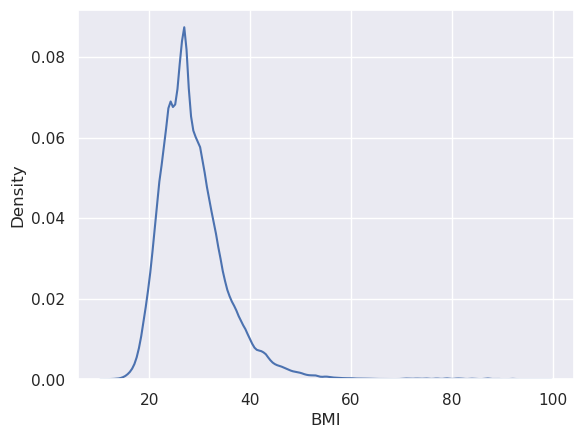

In [87]:
sns.kdeplot(data=df, x='BMI')

In [88]:
# categorize BMI
# function to assign BMI category
def categorize_bmi(value):

    """This function takes a BMI value and checks which range it falls in.
    It then returns which category of BMI the given value falls in."""
    
    if value < 18.5:
        return 1
    elif value>=18.5 and value<=24.9:
        return 2
    elif value>=25.0 and value<=29.9:
        return 3
    elif value>=30.0 and value<=39.9:
        return 4
    elif value>=40.0:
        return 5

In [89]:
df['BMICat'] = df['BMI'].apply(categorize_bmi)

### Assess Diet

In [90]:
df[['Fruits', 'Veggies']].corr()

,Fruits,Veggies
Fruits,1.000000,0.243114
Veggies,0.243114,1.000000


In [94]:
# aggregate with logical OR, and invert the results
df['Diet'] = 1 - (df.Fruits.astype(int) | df.Veggies.astype(int))
df[['Fruits', 'Veggies', 'Diet']].head()

# not eating fruits or vegetables has a worse prognosis, and so has a higher score, as with the rest of the data

,Fruits,Veggies,Diet
0,0.0,1.0,0
1,0.0,0.0,1
2,1.0,0.0,0
3,1.0,1.0,0
4,1.0,1.0,0


### Assess socials

In [95]:
df[['Smoker', 'HvyAlcoholConsump']].corr()

,Smoker,HvyAlcoholConsump
Smoker,1.000000,0.096052
HvyAlcoholConsump,0.096052,1.000000


In [97]:
df['Socials'] = df.Smoker.astype(int) | df.HvyAlcoholConsump.astype(int)
df[['Smoker', 'HvyAlcoholConsump', 'Socials']].head()

,Smoker,HvyAlcoholConsump,Socials
0,1.0,0.0,1
1,1.0,0.0,1
2,0.0,0.0,0
3,0.0,0.0,0
4,0.0,0.0,0


# Feature Selection

In [98]:
df.columns

Index(['Diabetes_012', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income',
       'PhysHlthCat', 'MentHlthCat', 'CostAccess', 'CVSScore', 'BMICat',
       'Diet', 'Socials'],
      dtype='object')

In [99]:
# drop unnecessary columns
new_df = df[['Diabetes_012', 'PhysActivity', 'GenHlth', 'Sex', 'Age', 'Education',
            'Income', 'PhysHlthCat', 'MentHlthCat', 'CostAccess', 'CVSScore', 'BMICat', 'Diet', 'Socials']]
new_df.info()
new_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 229781 entries, 0 to 253679
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Diabetes_012  229781 non-null  float64
 1   PhysActivity  229781 non-null  float64
 2   GenHlth       229781 non-null  float64
 3   Sex           229781 non-null  float64
 4   Age           229781 non-null  float64
 5   Education     229781 non-null  float64
 6   Income        229781 non-null  float64
 7   PhysHlthCat   229781 non-null  int64  
 8   MentHlthCat   229781 non-null  int64  
 9   CostAccess    229781 non-null  float64
 10  CVSScore      229781 non-null  float64
 11  BMICat        229781 non-null  int64  
 12  Diet          229781 non-null  int64  
 13  Socials       229781 non-null  int64  
dtypes: float64(9), int64(5)
memory usage: 26.3 MB


,Diabetes_012,PhysActivity,GenHlth,Sex,Age,Education,Income,PhysHlthCat,MentHlthCat,CostAccess,CVSScore,BMICat,Diet,Socials
0,0.0,0.0,5.0,0.0,9.0,4.0,3.0,3,3,1.0,2.0,5,0,1
1,0.0,1.0,3.0,0.0,7.0,6.0,1.0,1,1,1.0,0.0,3,1,1
2,0.0,0.0,5.0,0.0,9.0,4.0,8.0,5,5,2.0,2.0,3,0,0
3,0.0,1.0,2.0,0.0,11.0,3.0,6.0,1,1,1.0,1.0,3,0,0
4,0.0,1.0,2.0,0.0,11.0,5.0,4.0,1,1,1.0,2.0,2,0,0


In [100]:
# convert cols to int
for col in new_df.columns:
    new_df[col] = new_df[col].astype(int)
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 229781 entries, 0 to 253679
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype
---  ------        --------------   -----
 0   Diabetes_012  229781 non-null  int64
 1   PhysActivity  229781 non-null  int64
 2   GenHlth       229781 non-null  int64
 3   Sex           229781 non-null  int64
 4   Age           229781 non-null  int64
 5   Education     229781 non-null  int64
 6   Income        229781 non-null  int64
 7   PhysHlthCat   229781 non-null  int64
 8   MentHlthCat   229781 non-null  int64
 9   CostAccess    229781 non-null  int64
 10  CVSScore      229781 non-null  int64
 11  BMICat        229781 non-null  int64
 12  Diet          229781 non-null  int64
 13  Socials       229781 non-null  int64
dtypes: int64(14)
memory usage: 26.3 MB


/tmp/ipykernel_4341/1554213029.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df[col] = new_df[col].astype(int)
/tmp/ipykernel_4341/1554213029.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df[col] = new_df[col].astype(int)
/tmp/ipykernel_4341/1554213029.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

In [106]:
new_df.to_csv(processed_data_path, index=False)

In [2]:
# combine wrangling into function for ease of processing
def wrangle(dataset):
    """ Perform the wrangling operation on data

    Args:
        dataset([str, dict/json]): data can be passed from a file with name as str,
            or from a dictionary with key:value pairs as col_name:col_value
    
    Return:
        pd.DataFrame
    """

    if type(dataset) == str:
        df = pd.read_csv(dataset)
    else:
        df = pd.DataFrame(dataset, index=[0])

    df.drop_duplicates(inplace=True)
    
    # helper function to categorize HlthDays
    def categorize_HlthDay(count):
        """ Put the days into categories.
            The count is the number of days of ill-health in the past month
            so, the fewer the better
            0 - 6: 1 (Excellent health)
            7 - 12: 2 (Very Good)
            13 - 18: 3 (Good)
            19 - 24: 4 (Poor)
            25 - 30: 5 (Very poor)

        Args:
            count(int/float): the count for a row
        
        Return:
            the category(str)
        """
        if count >= 25:
            return (5)
        elif count >= 19:
            return (4)
        elif count >= 13:
            return (3)
        elif count >= 7:
            return (2)
        else:
            return (1)

    df['PhysHlthCat'] = df['PhysHlth'].apply(categorize_HlthDay)
    df['MentHlthCat'] = df['MentHlth'].apply(categorize_HlthDay)

    # aggregate cols
    df['CostAccess'] = df['AnyHealthcare'] + df['NoDocbcCost']
    df['CVSScore'] = df['HighBP'] + df['HighChol'] + df['Stroke'] + df['HeartDiseaseorAttack']


    # helper function to assign BMI into categories
    def categorize_bmi(value):

        """This function takes a BMI value and checks which range it falls in.
        It then returns which category of BMI the given value falls in."""
        
        if value < 18.5:
            return 1
        elif value>=18.5 and value<=24.9:
            return 2
        elif value>=25.0 and value<=29.9:
            return 3
        elif value>=30.0 and value<=39.9:
            return 4
        elif value>=40.0:
            return 5

    df['BMICat'] = df['BMI'].apply(categorize_bmi)
        
    df['Diet'] = 1 - (df.Fruits.astype(int) | df.Veggies.astype(int))

    df['Socials'] = df.Smoker.astype(int) | df.HvyAlcoholConsump.astype(int)

    new_df = df[['Diabetes_012', 'PhysActivity', 'GenHlth', 'Sex', 'Age', 'Education',
            'Income', 'PhysHlthCat', 'MentHlthCat', 'CostAccess', 'CVSScore', 'BMICat', 'Diet', 'Socials']]
    
    # convert to int
    for col in new_df.columns:
        new_df[col] = new_df[col].astype(int)
    
    return (new_df)

# Model Building

In [5]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import make_pipeline as imb_pipe
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
# from xgboost import XGBClassifier
# from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier

In [4]:
model_df = pd.read_csv(processed_data_path)
model_df.info()
model_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229781 entries, 0 to 229780
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype
---  ------        --------------   -----
 0   Diabetes_012  229781 non-null  int64
 1   PhysActivity  229781 non-null  int64
 2   GenHlth       229781 non-null  int64
 3   Sex           229781 non-null  int64
 4   Age           229781 non-null  int64
 5   Education     229781 non-null  int64
 6   Income        229781 non-null  int64
 7   PhysHlthCat   229781 non-null  int64
 8   MentHlthCat   229781 non-null  int64
 9   CostAccess    229781 non-null  int64
 10  CVSScore      229781 non-null  int64
 11  BMICat        229781 non-null  int64
 12  Diet          229781 non-null  int64
 13  Socials       229781 non-null  int64
dtypes: int64(14)
memory usage: 24.5 MB


,Diabetes_012,PhysActivity,GenHlth,Sex,Age,Education,Income,PhysHlthCat,MentHlthCat,CostAccess,CVSScore,BMICat,Diet,Socials
0,0,0,5,0,9,4,3,3,3,1,2,5,0,1
1,0,1,3,0,7,6,1,1,1,1,0,3,1,1
2,0,0,5,0,9,4,8,5,5,2,2,3,0,0
3,0,1,2,0,11,3,6,1,1,1,1,3,0,0
4,0,1,2,0,11,5,4,1,1,1,2,2,0,0


In [5]:
model_names = []
training_scores = []
testing_scores = []


def run_models(model):
    """ Function to build and score models
    
    Args:
        model (scikit learn model)
        
    Return:
        No return
    """

    setattr(model, 'random_state', 42)
    model_name = str(model)[:-2].title()

    # make pipeline with
    model_pipe = imb_pipe(
        RandomOverSampler(random_state=42),
        model
    )
    model_pipe.fit(X_train, y_train)

    # make predictions
    train_pred = model_pipe.predict(X_train)
    test_pred = model_pipe.predict(X_test)

    # score
    train_score = np.round(accuracy_score(y_train, train_pred) * 100, 2)
    test_score = np.round(accuracy_score(y_test, test_pred) * 100, 2)

    # append values to list
    model_names.append(model)
    training_scores.append(train_score)
    testing_scores.append(test_score)

    # output
    print(f"Scores for {str(model).upper()}")
    print(f"Accuracy on Training Data: {train_score}")
    print(f"Accuracy on Testing Data: {test_score}")
    print("\n--------------------------------------------------------------------------------------\n")
    print(f"Precision:'\t{np.round(precision_score(y_test, test_pred, average=None)*100, decimals=2)}")
    print(f"Recall:'\t{np.round(recall_score(y_test, test_pred, average=None)*100, decimals=1)}")
    print(f"f1_score:\t{np.round(f1_score(y_test, test_pred, average=None)*100, decimals=2)}")
    print(f"Confusion:'\n{confusion_matrix(y_test, test_pred)}")

    print("\n--------------------------------------------------------------------------------------\n")

    # create axes for two figures
    fig = plt.figure(figsize=(8,4))

    # create axes for first plot, the heatmap
    ax1 = fig.add_subplot(1,2,1)
    sns.heatmap(confusion_matrix(y_test, test_pred), cmap='Blues')
    ax1.set_xlabel("Actual")
    ax1.set_ylabel("Predicted")
    ax1.set_title("Confusion Matrix");

    # create subplot for second plot, the comparison plot
    ax2 = fig.add_subplot(1,2,2)
    sns.countplot(x=y_test, color='r');
    sns.countplot(x=test_pred, color='b', alpha=0.5);
    ax2.legend(['Actual', 'Predicted']);
    # ax2.set_xticklabels(['False', 'True'])
    ax2.set_xlabel("Predictions")
    ax2.set_ylabel("Frequency")
    ax2.set_title("Comparison of Predictions")

    plt.suptitle(f"Metrics for {model_name}: {test_score}")

    fig.tight_layout()

In [6]:
y = model_df['Diabetes_012']
X = model_df.drop(columns=['Diabetes_012'])

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.01, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(227483, 13)
(227483,)
(2298, 13)
(2298,)


Scores for LOGISTICREGRESSION(RANDOM_STATE=42)
Accuracy on Training Data: 63.34
Accuracy on Testing Data: 63.05

--------------------------------------------------------------------------------------

Precision:'	[93.68  2.84 38.3 ]
Recall:'	[64.4 28.6 60.2]
f1_score:	[76.31  5.16 46.82]
Confusion:'
[[1216  331  342]
 [  16   12   14]
 [  66   80  221]]

--------------------------------------------------------------------------------------



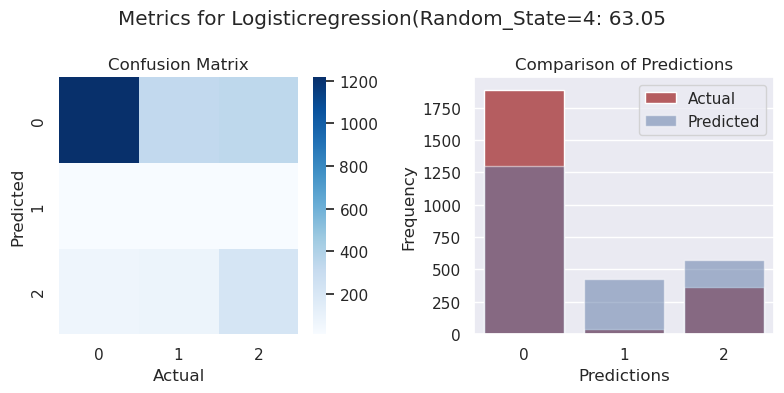

In [8]:
# logistic regression
run_models(LogisticRegression())

Scores for RIDGECLASSIFIER(RANDOM_STATE=42)
Accuracy on Training Data: 68.12
Accuracy on Testing Data: 68.19

--------------------------------------------------------------------------------------

Precision:'	[92.72  2.71 37.61]
Recall:'	[69.5 14.3 67.8]
f1_score:	[79.42  4.56 48.4 ]
Confusion:'
[[1312  180  397]
 [  20    6   16]
 [  83   35  249]]

--------------------------------------------------------------------------------------



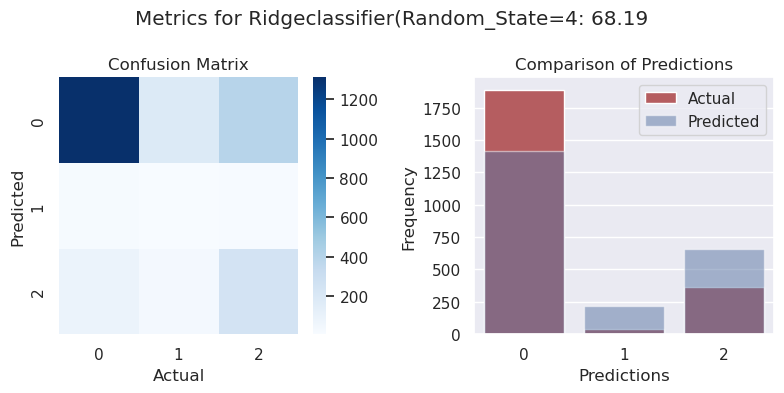

In [9]:
# ridgeclassifier
run_models(RidgeClassifier())

In [34]:
# knn
run_models(KNeighborsClassifier())

In [ ]:
# gradientboost
run_models(GradientBoostingClassifier())

In [6]:
XGBClassifier?

Object `XGBClassifier` not found.
